In [1]:
import os
data_file_path = "data/"

dir_list = os.listdir(data_file_path)

In [2]:
dir_list_by_parameter = list(map(lambda x: x.split(":"), dir_list))

# dir_list_by_parameter[0]
# ['g_16000', 'p_10', 'wc_10', 'gs_42', 'ss_10', 'ipmutp_0.01', 'icmutp_0.005', 'icmaxsw_5', 'ccmutp_0.01.csv']
VARIABLE_A_INDEX = 6
VARIABLE_B_INDEX = 7

# extract unique numbers (ipmutp) and seeds
unique_ip_mut = set()
unique_seeds = set()
for i in range(len(dir_list_by_parameter)):
  unique_ip_mut.add(dir_list_by_parameter[i][VARIABLE_A_INDEX].split("_")[1])
  unique_seeds.add(dir_list_by_parameter[i][4].split("_")[1])

print(f"{len(unique_ip_mut)}, {len(unique_seeds)}")

15, 40


In [3]:
import pandas as pd

max_iters = 1500

fdf = pd.DataFrame()
for file in dir_list:
  ip_mut = float(file.split(":")[VARIABLE_A_INDEX].split("_")[1])
  seed = int(file.split(":")[4].split("_")[1])
  
  if seed not in [1]:
    continue
  
  df = pd.read_csv(f"{data_file_path}/{file}")
  df.rename(columns={'Unnamed: 0': 'generation'}, inplace=True)
  df['seed'] = [seed for _ in range(len(df))]
  df['ip_mut'] = [ip_mut for _ in range(len(df))]
  fdf = pd.concat((fdf, df[:max_iters]))

fdf.describe()

,generation,per_it_avg_total_length,per_it_avg_max_path_length,per_it_avg_fitness,per_it_best_fitness,seed,ip_mut
count,90000.000000,90000.000000,90000.000000,9.000000e+04,9.000000e+04,90000.0,90000.000000
mean,749.500000,52463.380192,5491.614637,3.108367e+08,9.469153e+07,1.0,0.097067
std,433.015011,6820.432552,2896.296689,2.252367e+08,5.279478e+07,0.0,0.093369
min,0.000000,40795.312683,1555.148010,1.576223e+07,1.486026e+07,1.0,0.001000
25%,374.750000,46879.714830,2805.205444,1.059923e+08,4.182501e+07,1.0,0.008000
50%,749.500000,50530.055842,5313.639253,2.823411e+08,1.014634e+08,1.0,0.080000
75%,1124.250000,57262.261064,7888.135772,4.829528e+08,1.315206e+08,1.0,0.160000
max,1499.000000,84512.217878,15048.647793,1.219544e+09,2.780830e+08,1.0,0.300000


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# ax = sns.lineplot(data=fdf, x="generation", y="per_it_best_fitness", hue="ip_mut", legend=False)
# ax.set(xscale="log")
# plt.show()

# fig = ax.get_figure()
# fig.savefig("konvergencna_krivka.png") 


In [5]:
import numpy as np

max_iters = 250

fdf2 = pd.DataFrame()
result_mean = np.zeros((4, 15))
result_cnt = np.zeros((4, 15))

result_max = np.zeros((4, 15))
result_min = np.ones((4, 15)) * 10000000000

probs = np.array([0.001, 0.002, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1, 0.12, 0.14, 0.16, 0.20, 0.25, 0.3])
ic_swap_qs = np.array([2, 3, 4, 5])

for file in dir_list:
  ip_mut = round(float(file.split(":")[VARIABLE_A_INDEX].split("_")[1]), 3)
  ic_swap = int(file.split(":")[VARIABLE_B_INDEX].split("_")[1])
  seed = int(file.split(":")[4].split("_")[1])
  
  if seed in [43]: # remove garbage
    continue
  
  df = pd.read_csv(f"{data_file_path}/{file}")
  df.rename(columns={'Unnamed: 0': 'generation'}, inplace=True)
  df['seed'] = [seed for _ in range(len(df))]
  df['ic_mut'] = [ip_mut for _ in range(len(df))]
  df['ic_swap'] = [ic_swap for _ in range(len(df))]
  cdf = df[df['generation'] == max_iters]
  
  # create heat map
  p_index = np.argwhere(probs == ip_mut).astype(int)[0][0]
  q_index = np.argwhere(ic_swap_qs == ic_swap).astype(int)[0][0]
  
  result_cnt[q_index][p_index] += 1
  result_mean[q_index][p_index] += np.mean(cdf['per_it_best_fitness'])
  
  result_max[q_index][p_index] = np.max((result_max[q_index][p_index], np.max(cdf['per_it_best_fitness'])))
  result_min[q_index][p_index] = np.min((result_min[q_index][p_index], np.min(cdf['per_it_best_fitness']))) 
  
  fdf2 = pd.concat((fdf2, cdf))

result_mean_final = result_mean / result_cnt
fdf2.describe()

,generation,per_it_avg_total_length,per_it_avg_max_path_length,per_it_avg_fitness,per_it_best_fitness,seed,ic_mut,ic_swap
count,2400.0,2400.000000,2400.000000,2.400000e+03,2.400000e+03,2400.000000,2400.000000,2400.000000
mean,250.0,51231.104490,5468.784998,3.152022e+08,1.232810e+08,20.500000,0.097067,3.500000
std,0.0,6394.686553,2759.045547,2.032502e+08,2.858193e+07,11.545802,0.093388,1.118267
min,250.0,40248.592619,1777.439766,3.486046e+07,3.311714e+07,1.000000,0.001000,2.000000
25%,250.0,46487.781504,2681.193691,1.266359e+08,1.049195e+08,10.750000,0.008000,2.750000
50%,250.0,49228.824986,5175.274761,2.744096e+08,1.206673e+08,20.500000,0.080000,3.500000
75%,250.0,55098.949818,7621.283941,4.556651e+08,1.407763e+08,30.250000,0.160000,4.250000
max,250.0,77974.242540,13841.104062,1.056695e+09,2.504066e+08,40.000000,0.300000,5.000000


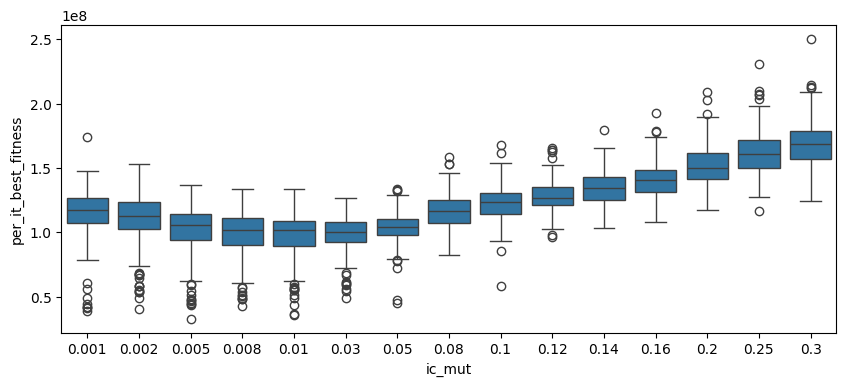

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.boxplot(ax=ax, data=fdf2, x="ic_mut", y="per_it_best_fitness")
plt.show()

fig = ax.get_figure()
fig.savefig("boxplot_end.png") 

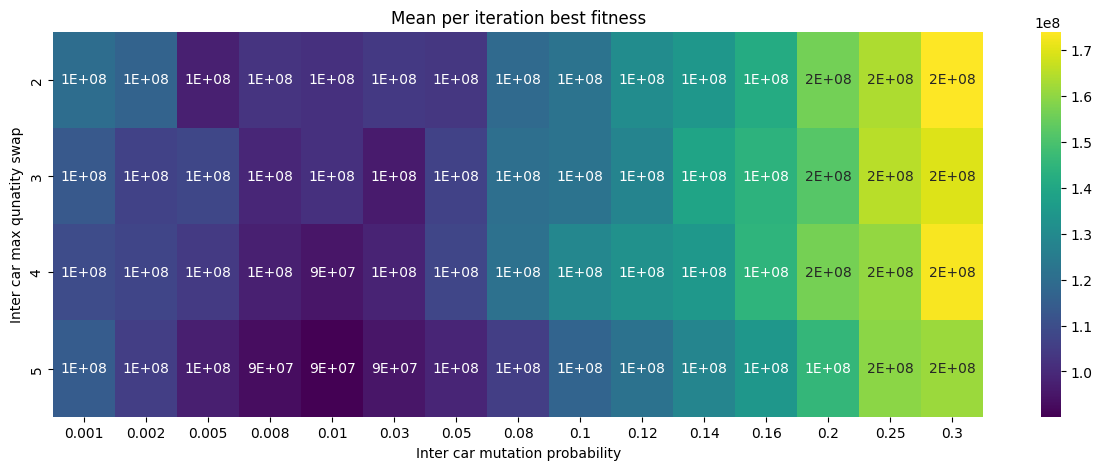

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(result_mean_final, annot=True, fmt="2.0E", cmap='viridis')
ax.set(xlabel="Inter car mutation probability", ylabel="Inter car max qunatity swap")
ax.set_title("Mean per iteration best fitness")
ax.set_xticklabels(probs)
ax.set_yticklabels(ic_swap_qs)
plt.show()

fig = ax.get_figure()
fig.savefig("mean_per_iteration_best_fitness.png") 

In [8]:
import duckdb
from scipy import stats

resdf_2 = duckdb.sql("SELECT * FROM fdf2 WHERE ic_mut = 0.03 AND ic_swap = 2").df()
resdf_5 = duckdb.sql("SELECT * FROM fdf2 WHERE ic_mut = 0.03 AND ic_swap = 5").df()
pibf_2 = resdf_2['per_it_best_fitness'].tolist()
pibf_5 = resdf_5['per_it_best_fitness'].tolist()

stat, pvalue = stats.mannwhitneyu(pibf_2, pibf_5)
print(f"P-value: {pvalue}")

P-value: 0.00035054874836943284


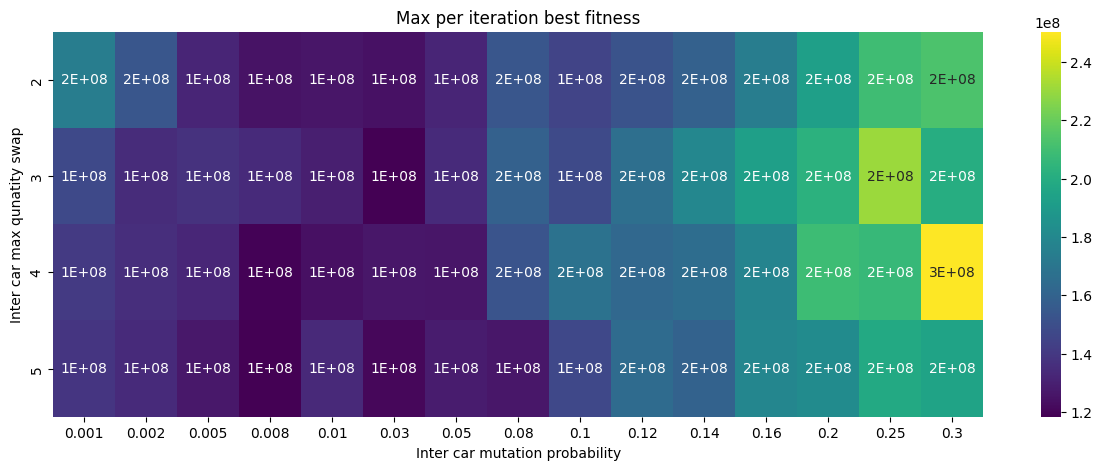

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(result_max, annot=True, fmt="2.0E", cmap='viridis')
ax.set(xlabel="Inter car mutation probability", ylabel="Inter car max qunatity swap")
ax.set_title("Max per iteration best fitness")
ax.set_xticklabels(probs)
ax.set_yticklabels(ic_swap_qs)
plt.show()

fig = ax.get_figure()
fig.savefig("max_per_iteration_best_fitness.png") 

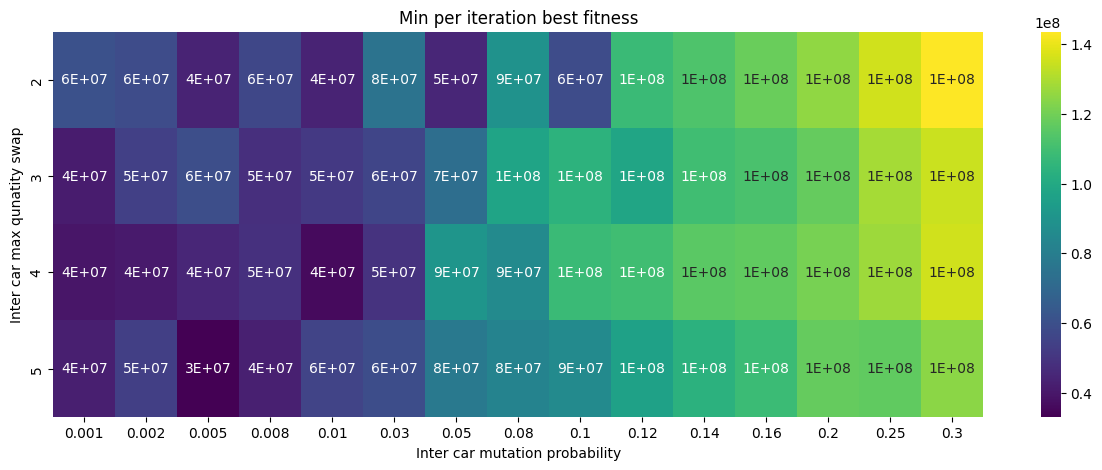

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(result_min, annot=True, fmt="3.0E", cmap='viridis')
ax.set(xlabel="Inter car mutation probability", ylabel="Inter car max qunatity swap")
ax.set_title("Min per iteration best fitness")
ax.set_xticklabels(probs)
ax.set_yticklabels(ic_swap_qs)
plt.show()

fig = ax.get_figure()
fig.savefig("min_per_iteration_best_fitness.png") 

In [11]:
max_iters = 1499

fdf2 = pd.DataFrame()
result_mean = np.zeros((4, 15))
result_cnt = np.zeros((4, 15))

result_max = np.zeros((4, 15))
result_min = np.ones((4, 15)) * 10000000000

probs = np.array([0.001, 0.002, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1, 0.12, 0.14, 0.16, 0.20, 0.25, 0.3])
ic_swap_qs = np.array([2, 3, 4, 5])

for file in dir_list:
  ip_mut = round(float(file.split(":")[VARIABLE_A_INDEX].split("_")[1]), 3)
  ic_swap = int(file.split(":")[VARIABLE_B_INDEX].split("_")[1])
  seed = int(file.split(":")[4].split("_")[1])
  
  if seed in [43]: # remove garbage
    continue
  
  df = pd.read_csv(f"{data_file_path}/{file}")
  df.rename(columns={'Unnamed: 0': 'generation'}, inplace=True)
  df['seed'] = [seed for _ in range(len(df))]
  df['ic_mut'] = [ip_mut for _ in range(len(df))]
  df['ic_swap'] = [ic_swap for _ in range(len(df))]
  cdf = df[df['generation'] == max_iters]
  
  # create heat map
  p_index = np.argwhere(probs == ip_mut).astype(int)[0][0]
  q_index = np.argwhere(ic_swap_qs == ic_swap).astype(int)[0][0]
  
  result_cnt[q_index][p_index] += 1
  result_mean[q_index][p_index] += np.mean(cdf['per_it_best_fitness'])
  
  result_max[q_index][p_index] = np.max((result_max[q_index][p_index], np.max(cdf['per_it_best_fitness'])))
  result_min[q_index][p_index] = np.min((result_min[q_index][p_index], np.min(cdf['per_it_best_fitness']))) 
  
  fdf2 = pd.concat((fdf2, cdf))

result_mean_final = result_mean / result_cnt
fdf2.describe()

,generation,per_it_avg_total_length,per_it_avg_max_path_length,per_it_avg_fitness,per_it_best_fitness,seed,ic_mut,ic_swap
count,2400.0,2400.000000,2400.000000,2.400000e+03,2.400000e+03,2400.000000,2400.000000,2400.000000
mean,1499.0,50015.389458,5566.502250,3.011055e+08,6.879654e+07,20.500000,0.097067,3.500000
std,0.0,7156.088578,3157.481526,2.421108e+08,4.135502e+07,11.545802,0.093388,1.118267
min,1499.0,35743.226604,1509.195413,1.644045e+07,1.213300e+07,1.000000,0.001000,2.000000
25%,1499.0,44655.818304,2101.432357,7.160073e+07,3.011646e+07,10.750000,0.008000,2.750000
50%,1499.0,47716.157321,5434.199430,2.752809e+08,6.106890e+07,20.500000,0.080000,3.500000
75%,1499.0,54239.060760,8234.183191,4.816682e+08,1.017466e+08,30.250000,0.160000,4.250000
max,1499.0,80570.522607,15845.052559,1.241418e+09,2.064208e+08,40.000000,0.300000,5.000000


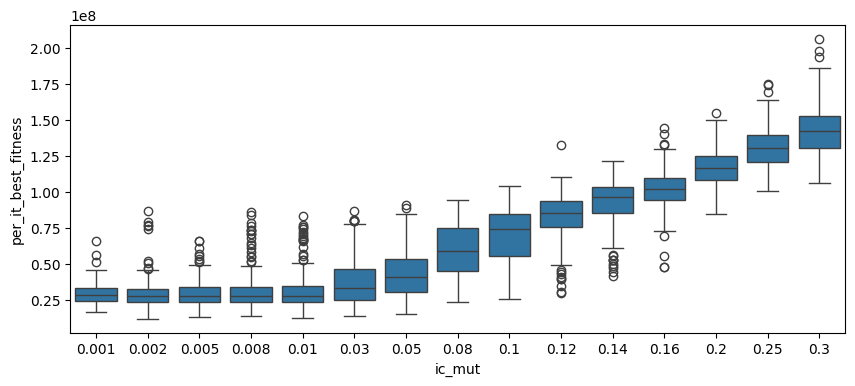

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.boxplot(ax=ax, data=fdf2, x="ic_mut", y="per_it_best_fitness")
plt.show()

fig = ax.get_figure()
fig.savefig("boxplot_end.png") 

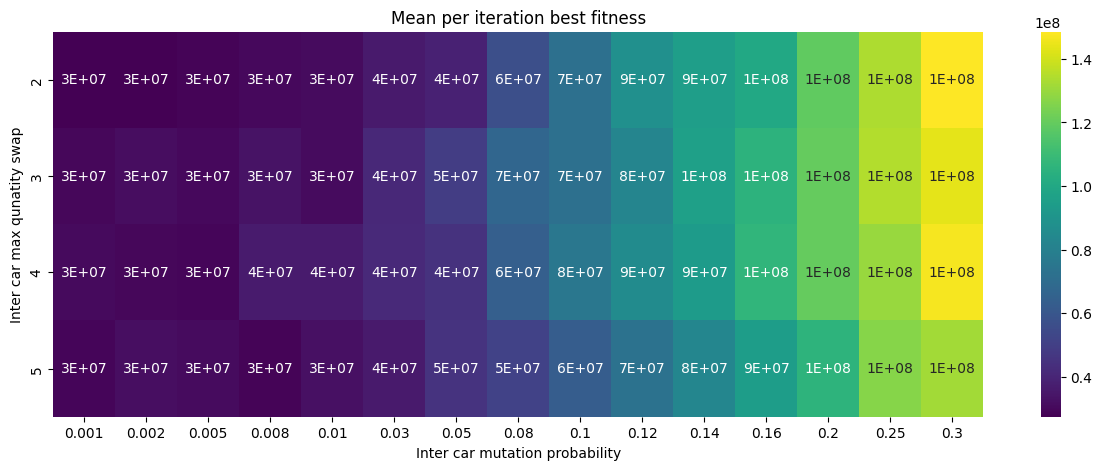

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(result_mean_final, annot=True, fmt="2.0E", cmap='viridis')
ax.set(xlabel="Inter car mutation probability", ylabel="Inter car max qunatity swap")
ax.set_title("Mean per iteration best fitness")
ax.set_xticklabels(probs)
ax.set_yticklabels(ic_swap_qs)
plt.show()

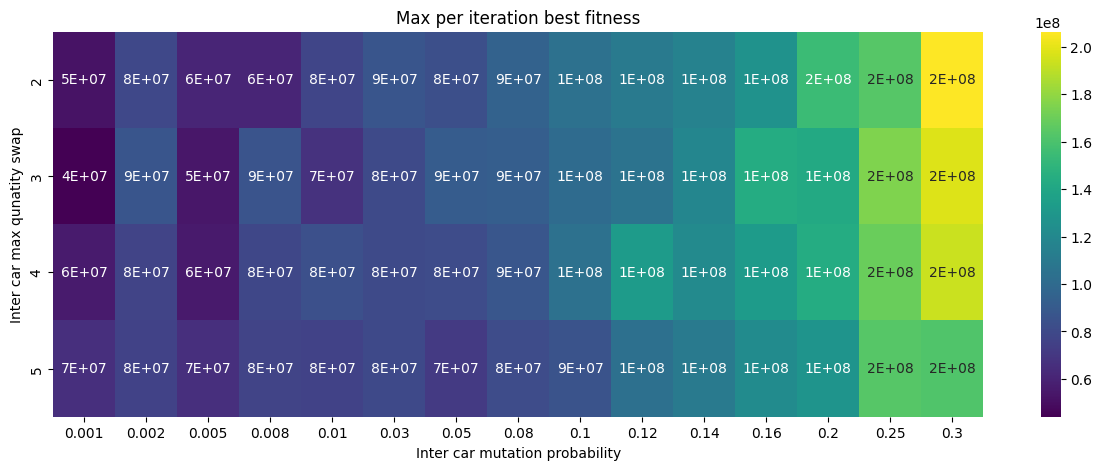

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(result_max, annot=True, fmt="2.0E", cmap='viridis')
ax.set(xlabel="Inter car mutation probability", ylabel="Inter car max qunatity swap")
ax.set_title("Max per iteration best fitness")
ax.set_xticklabels(probs)
ax.set_yticklabels(ic_swap_qs)
plt.show()

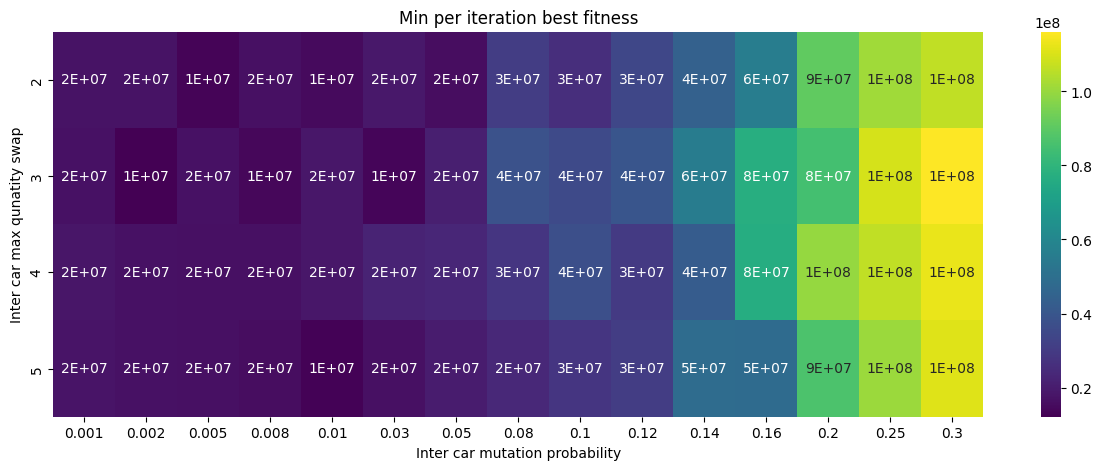

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(result_min, annot=True, fmt="3.0E", cmap='viridis')
ax.set(xlabel="Inter car mutation probability", ylabel="Inter car max qunatity swap")
ax.set_title("Min per iteration best fitness")
ax.set_xticklabels(probs)
ax.set_yticklabels(ic_swap_qs)
plt.show()